<a href="https://colab.research.google.com/github/katduecker/dnn_osci/blob/main/DynNN_figures_thesis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Settings - Paths - Clone github rep

In [37]:
# mount google drive
from google.colab import drive
drive.mount('/content/drive')

# clone github
!git clone https://github.com/katduecker/dnn_osci

# enter folder
%cd dnn_osci
%cd aet_pytorch/


load_NN = False       # load pre-trained NN?
save_NN = False       # save trained NN?

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Cloning into 'dnn_osci'...
remote: Enumerating objects: 612, done.
remote: Counting objects: 100% (199/199), done.
remote: Compressing objects: 100% (126/126), done.
remote: Total 612 (delta 99), reused 142 (delta 73), pack-reused 413
Receiving objects: 100% (612/612), 193.28 MiB | 14.01 MiB/s, done.
Resolving deltas: 100% (317/317), done.
/content/dnn_osci/aet_pytorch/dnn_osci/aet_pytorch/dnn_osci
/content/dnn_osci/aet_pytorch/dnn_osci/aet_pytorch/dnn_osci/aet_pytorch


In [38]:
# import packages

import torch
from torch import nn
import numpy as np

# get CUDA index
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
# colours for plot
col = mcolors.TABLEAU_COLORS

from itertools import combinations


plt.rcParams["figure.figsize"] = (18,3)

font = {'weight' : 'normal',
        'size'   : 14,
        'family' : 'sans-serif'}
plt.rc('font',**font)

In [39]:
import aet_net            # 1-layer architecture
import aet_net_2lay       # 2-layer architecture



## Helper functions

In [40]:
# sigmoid activation with option to stretch and shift
def sigmoid(z,sig_param):

    _slope,_bias = sig_param

    return 1.0/(1.0+np.exp(-_slope*(z+_bias)))

In [41]:
# forward dynamics/discretization, euler integration
def euler_dyn(Z,t_,params_,alpha_params_,sig_param,t_start=0):

    # inputs:
        # input_: input image
        # params_: hyperparameters
        # t_: time vector for integration
        # alpha_params: alpha frequency & amplitude

    # discretization & dynamics parameters
    tau_h,tau_R,c,S = params_


    # alpha frequency & amplitude
    _af,_aa,_ap = alpha_params_


    # initialize empty matrices
    dt = np.diff(t_)[0]
    dh1dt = (np.zeros((len(t_)+1,)))
    dR1dt = (np.zeros((len(t_)+1,)))
    dZdt = (np.zeros((len(t_)+1,)))

    # alpha inhibition
    alpha_inh1 = _aa*np.sin(2*np.pi*_af*t_+_ap)+_aa

    boxcar = np.zeros(len(t_))
    boxcar[t_start:] = 1

    for _it,t in enumerate(t_):

        # pre-activation
        dZdt[_it+1] = (Z*boxcar[_it] + dh1dt[_it] - dR1dt[_it] - alpha_inh1[_it])/S

        # dynamics hidden layer1
        dh1dt[_it+1] = dh1dt[_it] + dt/tau_h * (-dh1dt[_it] + sigmoid(dZdt[_it+1],sig_param))

        # adaptation term 1
        dR1dt[_it+1] = dR1dt[_it] + dt/tau_R * (-dR1dt[_it] + c*dh1dt[_it+1])



    return dZdt, dh1dt, dR1dt

In [42]:
# 2-layer NN Euler

# scaled c to each Z

def euler_dyn_2layer(model,input_,params_,t_,alpha_params,DEVICE,inp_on,start_fix = True):

    # inputs:
        # input_: input image
        # params_: hyperparameters
        # t_: time vector for integration
        # alpha_params: alpha frequency & amplitude

    # discretization & dynamics parameters
    tau_h,tau_R,c,S = params_


    # alpha frequency & amplitude
    _af,_aa,_aph = alpha_params


    with torch.no_grad():

        # preactivation (dot product of input and first weight matrix)
        Z,H,_,_= model.forw_conv(input_)
        Z2 = model.fc1(H)

        # initialize empty matrices
        dt = np.diff(t_)[0]
        dh1dt = (torch.ones((model.dims[1],len(t_)+1))).to(DEVICE)
        dR1dt = (torch.zeros((model.dims[1],len(t_)+1))).to(DEVICE)



        dh2dt = (torch.zeros((model.dims[2],len(t_)+1))).to(DEVICE)
        dR2dt = (torch.zeros((model.dims[2],len(t_)+1))).to(DEVICE)

        if start_fix:

          # start at fixed point
          dR1dt[:,0] = (c/(c-1))*Z
          dh1dt[:,0] = Z/(c-1)


          # start at fixed point
          dR2dt[:,0] = (c/(c-1))*Z2
          dh2dt[:,0] = Z2/(c-1)



        dOdt = (torch.zeros((model.dims[3],len(t_)+1))).to(DEVICE)
        dZdt = (torch.zeros((model.dims[1],len(t_)+1))).to(DEVICE)
        dZ2dt = (torch.ones((model.dims[2],len(t_)+1))).to(DEVICE)

        # alpha inhibition
        alpha_inh1 = _aa[0]*np.sin(2*np.pi*_af[0]*t_+_aph[0])+_aa[0]
        alpha_inh2 = _aa[1]*np.sin(2*np.pi*_af[1]*t_+_aph[0])+_aa[1]




        # create boxcar function to try different input onsets
        boxcar = np.zeros_like(t_)
        boxcar[inp_on:] = 1

        for _it,t in enumerate(t_):

            # dynamic input: multiply input with boxcar
            Z,H1,H2,O = model.forw_conv(input_*boxcar[_it])

          # pre-activation
            dZdt[:,_it+1] = (Z + dh1dt[:,_it] - dR1dt[:,_it] - alpha_inh1[_it])/S

            # dynamics hidden layer
            dh1dt[:,_it+1] = dh1dt[:,_it] + dt/tau_h * (-dh1dt[:,_it] + model.acti1(dZdt[:,_it+1],model.sig_param[0]))

            # adaptation term
            dR1dt[:,_it+1] = dR1dt[:,_it] + dt/tau_R * (-dR1dt[:,_it] + c*dh1dt[:,_it+1])


            # pre-activation layer 2
            Z2 =  model.fc1(H1)

            dZ2dt[:,_it+1] = (model.fc1(dh1dt[:,_it+1]) + dh2dt[:,_it+1] - dR2dt[:,_it]- alpha_inh2[_it])/S
            # dynamics hidden layer1
            dh2dt[:,_it+1] = dh2dt[:,_it] + dt/tau_h * (-dh2dt[:,_it] + aet_net_2lay.sigmoid(dZ2dt[:,_it+1],model.sig_param[1]))

            # # adaptation term 2
            dR2dt[:,_it+1] = dR2dt[:,_it] + dt/tau_R * (-dR2dt[:,_it] + c*dh2dt[:,_it+1])

            # output layer
            dOdt[:,_it+1] = model.actiout(model.fc2(dh2dt[:,_it+1]))

    return dZdt, dZ2dt, dh1dt, dR1dt, dh2dt, dR2dt,dOdt

In [43]:
# create stimuli

x_train, y_train = aet_net_2lay.aet_stim.mkstim()
x_train = x_train.to(DEVICE)
y_train = y_train.to(DEVICE)

# Train network

In [44]:
nn_dim_ = [28,64,32,3]   # [quadrant size, number of hidden nodes, number of output nodes]
eta_ = 1e-3           # learning rate
mini_sz_ = 1          # mini batch size (1 = use SGD)
num_epo_ = 40

beta_ = 0
p_ = .02              # has to be != 0 even if not used
kl_reg_ = [beta_,p_,1]#[0,0.001] # sparsity constraint parameters (not used for manual model)
sig_param =[[2, -2.5, False],[2, -2.5, False]] # sigmoid slope and shift in x direction

ortho_lmbda = 0
ortho_layer = 2

# loss function & final layer activation (for binary crossentropy use sigmoid)
lossfun = [nn.MSELoss(), nn.Softmax(dim=-1)]

params = nn_dim_,eta_,mini_sz_,num_epo_,kl_reg_,sig_param,ortho_lmbda,ortho_layer


if load_NN:
  model2 = torch.load("/content/drive/MyDrive/dnn_osci/aet_pytorch/trained model/model_2layer_temp_code_works.pt")

else:

  # initialize model and weights
  model2 = aet_net_2lay.net(params,lossfun)
  model2 = aet_net_2lay.init_params(model2,weight_init='uni')

  optimizer = torch.optim.Adam(model2.parameters(),lr=eta_)

  model2.to(DEVICE)
  loss_hist2 = model2.train(optimizer,noise=False,print_loss=False)

In [45]:
# hidden layer activations

Z21,H21,H22,O2 = model2.forw_conv(x_train)

Z22 = model2.fc1(H21)

In [46]:
idx = np.array((0,4,8))
label = ['A','E','T']

In [47]:
font = {'weight' : 'normal',
        'size'   : 10,
        'family' : 'sans-serif'}
plt.rc('font',**font)


plt.rcParams["figure.figsize"] = (8.9,8)


fig = plt.figure(layout="constrained")
gs0 = fig.add_gridspec(1, 2)

gs00 = gs0[0].subgridspec(1, 1)
gs01 = gs0[1].subgridspec(2, 2)

<Figure size 890x800 with 0 Axes>

# Plot network

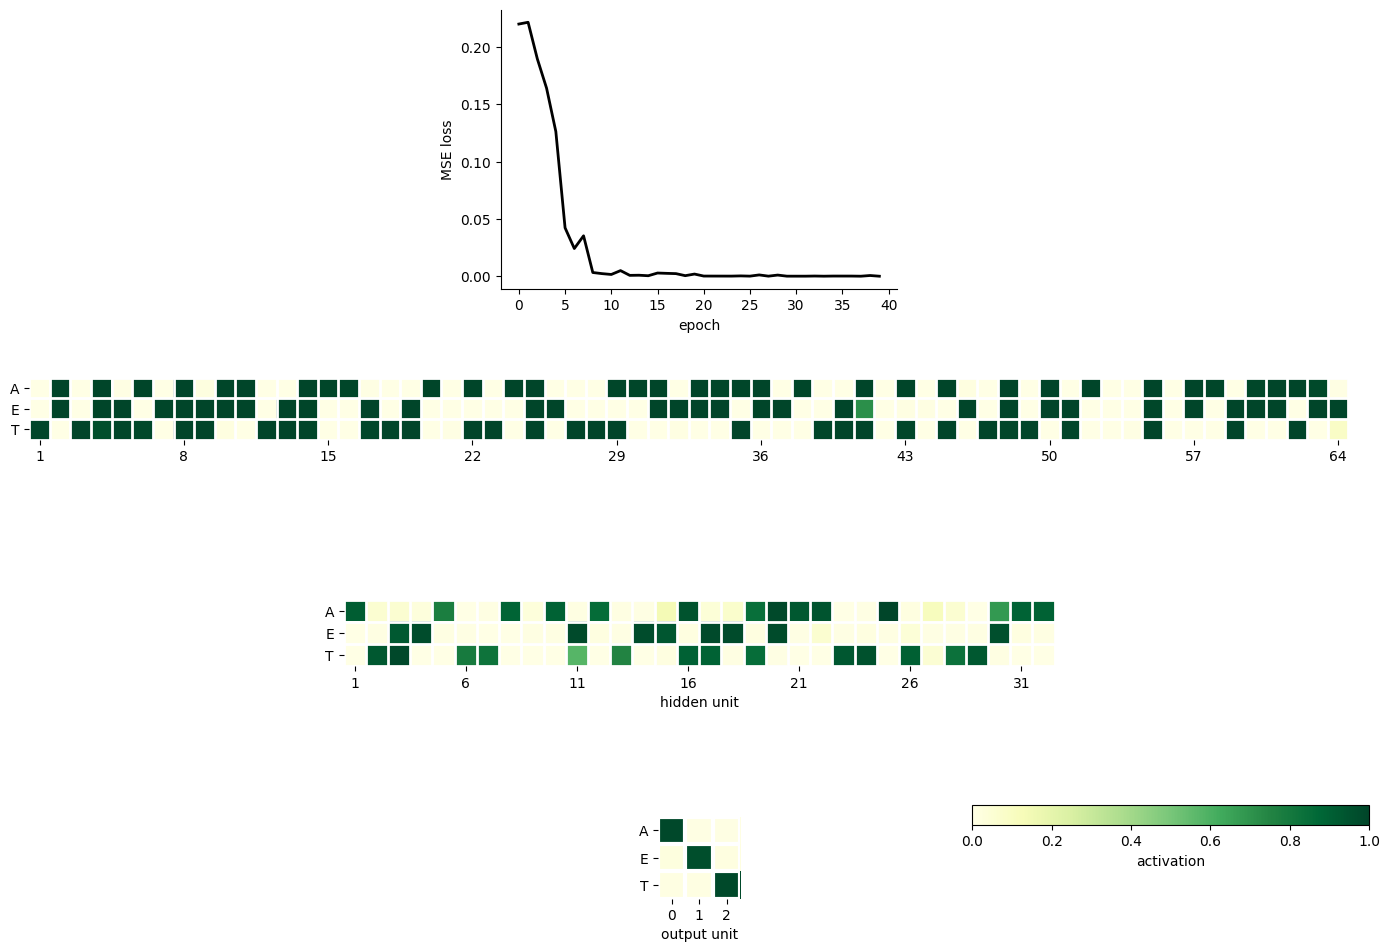

In [48]:
# plot

from matplotlib.gridspec import GridSpec


font = {'weight' : 'normal',
        'size'   : 10,
        'family' : 'sans-serif'}
plt.rc('font',**font)


plt.rcParams["figure.figsize"] = (14,10)


fig = plt.figure()

gs = GridSpec(4, 9, figure=fig,height_ratios = [1, .75, 0.75, .75])
ax1 = fig.add_subplot(gs[0, 3:6])
# identical to ax1 = plt.subplot(gs.new_subplotspec((0, 0), colspan=3))
ax2 = fig.add_subplot(gs[1,:])
ax3 = fig.add_subplot(gs[2, 2:7])
ax4 = fig.add_subplot(gs[3, 4:5])
ax5 = fig.add_subplot(gs[3, 6:])

ax1.spines[['right', 'top']].set_visible(False)
ax1.set_xlabel('epoch')
ax1.set_ylabel('MSE loss')
ax1.plot(np.arange(num_epo_),loss_hist2.detach().cpu(),color='k',linewidth=2)

ax2.imshow(H21[idx].detach().cpu().numpy(),cmap='YlGn',interpolation='nearest',aspect=1)
ax2.set_xticks(np.arange(0,64,7))
ax2.set_xticklabels(np.arange(1,65,7))
ax2.set_yticks(np.arange(3))
ax2.set_yticks(np.arange(-0.5, 3, 1), minor=True)
ax2.set_xticks(np.arange(-0.5, 65, 1), minor=True)
ax2.grid(which="minor", color="w", linestyle='-', linewidth=2)
ax2.tick_params(which='minor', bottom=False, left=False)


ax2.set_yticklabels(['A', 'E','T'])
ax2.spines[:].set_visible(False)

ax3.imshow(H22[idx].detach().cpu().numpy(),cmap='YlGn',interpolation='nearest', aspect=1)
ax3.set_xticks(np.arange(0,32,5))
ax3.set_xticklabels(np.arange(1,32,5))

ax3.set_yticks(np.arange(3))
ax3.set_yticks(np.arange(-0.5, 3, 1), minor=True)
ax3.set_xticks(np.arange(-0.5, 32, 1), minor=True)
ax3.grid(which="minor", color="w", linestyle='-', linewidth=2)
ax3.tick_params(which='minor', bottom=False, left=False)

ax3.spines[:].set_visible(False)

ax3.set_yticks(np.arange(3))
ax3.set_yticklabels(['A', 'E','T'])
ax3.set_xlabel('hidden unit')

im4 = ax4.imshow(O2[idx].detach().cpu().numpy(),cmap='YlGn',interpolation='nearest',aspect=1 )
ax4.set_xticks(np.arange(0,3,1))
ax4.set_xticklabels(np.arange(3))

ax4.set_yticks(np.arange(3))
ax4.set_yticks(np.arange(-0.5, 3, 1), minor=True)
ax4.set_xticks(np.arange(-0.5, 3, 1), minor=True)
ax4.grid(which="minor", color="w", linestyle='-', linewidth=3)
ax4.tick_params(which='minor', bottom=False, left=False)

ax4.spines[:].set_visible(False)

ax4.set_yticks(np.arange(3))
ax4.set_yticklabels(['A', 'E','T'])
ax4.set_xlabel('output unit')
ax4.set_xlim([-0.5, 2.5])
ax5.axis('off')
im4.set_clim(0,1)
cb = fig.colorbar(im4,ax=ax5,orientation='horizontal',fraction=.75)
cb.set_label('activation')

fig.tight_layout()
plt.show()

# Explore dynamics single neuron

Dynamics in each hidden unit

$\tau_H \frac{dH_j}{dt} = -H_j + \sigma (a \frac{Z_j - R_j - \alpha (t) + H_j}{S} - b)$


Relaxation dynamics

$\tau_R = \frac{dR_j}{dt} = -R_j + c \cdot H_j$

### Explore best settings for *c*


According to linear stability analysis, the frequency of the oscillations is defined as

$$
f_0 = \frac{1}{2\pi}
\sqrt{ 4 c \; \frac{\tau_H}{\tau_R} \; \frac{a}{S} \; H^* (1 - H^* ) - \left( \frac{a}{S} \; H^* (1 - H^* ) + \frac{\tau_H}{\tau_R} - 1 \right)^2 }
$$

with $H^* = \frac{Z}{c-1} $.

$f = \frac{f_0}{\tau_H}$ is the frequency in Hz

We are now trying to explore optimum parameters for $c$

### How do the dynamics change as a function of c?

<ipython-input-49-418695048490>:48: RuntimeWarning: invalid value encountered in sqrt
  predf[i] = (1/(2*np.pi) * np.sqrt(4*c*(tau_h/tau_R)*(a/S)*Hx*(1-Hx) - ((a/S)*Hx*(1-Hx)+(tau_h/tau_R)-1)**2))/tau_h
<ipython-input-49-418695048490>:100: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[1,1].set_xticklabels(np.round(np.arange(c_vec[0],c_vec[-1]+1,4),decimals=1))
<ipython-input-49-418695048490>:126: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[1,0].set_xticklabels(np.round(np.arange(c_vec[0],c_vec[-1]+1,4),decimals=1))


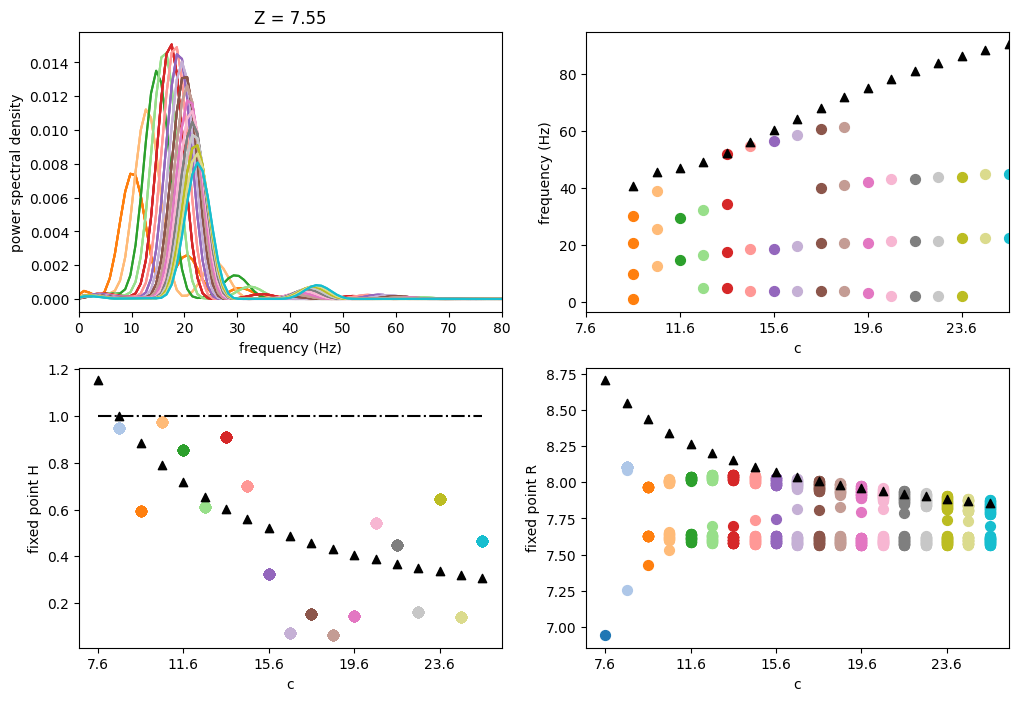

In [49]:
## The effect of c on the dynamics

cmap = plt.get_cmap('tab20')
import scipy

tau_h = 0.01
tau_R = 0.1
S = .1
a = 2

alpha_params = [10,0,0]
sig_param = [2, -2.5]


# explore the maximum value for Z (dot product)
Z = torch.max(Z21).detach().cpu().item()

# time
timevec = np.linspace(0,2,2000)

# explore c's
c_vec = np.arange(Z,3.5*Z,1)


Pxx = np.zeros((c_vec.shape[0],513))


plt.rcParams["figure.figsize"] = (12,8)

fig, axs = plt.subplots(2,2)

predf = np.zeros_like(c_vec)

## FREQUENCY
for i,c in enumerate(c_vec):
  params = [tau_h,tau_R,c,S]
  Zt, Ht, Rt = euler_dyn(Z,timevec,params,alpha_params,sig_param,t_start=0)

  f,Pxx[i] = scipy.signal.welch(Ht,fs=1000,nfft=1024)

  idx = scipy.signal.find_peaks(Pxx[i],prominence=(0.0001,None))

  freq = f[idx[0]]
  pow = idx[1]['prominences']

# predicted frequency
  Hx = Z/(c-1)
  predf[i] = (1/(2*np.pi) * np.sqrt(4*c*(tau_h/tau_R)*(a/S)*Hx*(1-Hx) - ((a/S)*Hx*(1-Hx)+(tau_h/tau_R)-1)**2))/tau_h

  for ii in range(len(freq)):
    #axs[0].text(freq[ii],pow[ii]+0.0005,str(round(c_vec[i])))
    axs[0,0].plot(f,Pxx[i],color=cmap(i)[0:3]);

for fi,pc in enumerate(Pxx):
  idx = scipy.signal.find_peaks(pc,prominence=(0.0001,None))

  freq = f[idx[0]]
  pow = idx[1]['prominences']

  for ii in range(len(freq)):
    axs[0,1].scatter(c_vec[fi],freq[ii],color=cmap(fi)[0:3],s=50)

  axs[0,1].scatter(c_vec[fi],predf[fi],color='k',marker="^")

axs[0,0].set_xlim((0, 80))
axs[0,0].set_xlabel('frequency (Hz)')
axs[0,0].set_ylabel('power spectral density')
axs[0,1].set_xlabel('c')
axs[0,1].set_xticks(np.arange(c_vec[0],c_vec[-1]+1,4))
axs[0,1].set_xticklabels(np.round(np.arange(c_vec[0],c_vec[-1]+1,4),decimals=1))
axs[0,0].set_title('Z = ' + str(round(Z,2)))

axs[0,1].set_ylabel('frequency (Hz)')
axs[0,1].set_xlim((c_vec[0], c_vec[-1]))


## FIXED POINTS
for i,c in enumerate(c_vec):
  params = [tau_h,tau_R,c,S]
  Zt, Ht, Rt = euler_dyn(Z,timevec,params,alpha_params,sig_param,t_start=0)

  dH = np.diff(Ht)

  mark_sign_chan = np.array(())
  for h in range(dH.shape[0]-1):
    if (np.sign(dH[h])+np.sign(dH[h+1])) == 0:
      mark_sign_chan = np.append(mark_sign_chan,h)


  rval = [Rt[int(m-1)] for i,m in enumerate(mark_sign_chan)]

  # actual fixed point
  axs[1,1].scatter(np.tile(c,(len(rval),1)),rval,color=cmap(i)[0:3],s=50)

  # predicted by linear stability analysis
  rfix = (c/(c-1)*Z)
  axs[1,1].scatter(c,rfix,color='k',marker="^")

  axs[1,1].set_xlabel('c')
  axs[1,1].set_xticklabels(np.round(np.arange(c_vec[0],c_vec[-1]+1,4),decimals=1))
  axs[1,1].set_xticks(np.arange(c_vec[0],c_vec[-1]+1,4))

  axs[1,1].set_ylabel('fixed point R')

  dR = np.diff(Rt)

  mark_sign_chan = np.array(())
  for r in range(dR.shape[0]-1):
    if (np.sign(dR[r])+np.sign(dR[r+1])) == 0:
      mark_sign_chan = np.append(mark_sign_chan,h)

  hval = [Ht[int(m-1)] for i,m in enumerate(mark_sign_chan)]

  # actual fixed point
  axs[1,0].scatter(np.tile(c,(len(hval),1)),hval,color=cmap(i)[0:3],s=50)




  # predicted by linear stability analysis
  hfix = Z/(c-1)
  axs[1,0].scatter(c,hfix,color='k',marker="^")


  axs[1,0].set_xlabel('c')
  axs[1,0].set_xticklabels(np.round(np.arange(c_vec[0],c_vec[-1]+1,4),decimals=1))
  axs[1,0].set_xticks(np.arange(c_vec[0],c_vec[-1]+1,4))

  axs[1,0].set_ylabel('fixed point H')

# what the fixed point shoild be
axs[1,0].plot(c_vec,np.ones_like(c_vec)*sigmoid(Z,[2,-2.5]),color='k',linestyle='-.')


The actual fixed point is reached for the 4th and 5th value, and dynamics are ~15 Hz

#### Investigate the fixed points

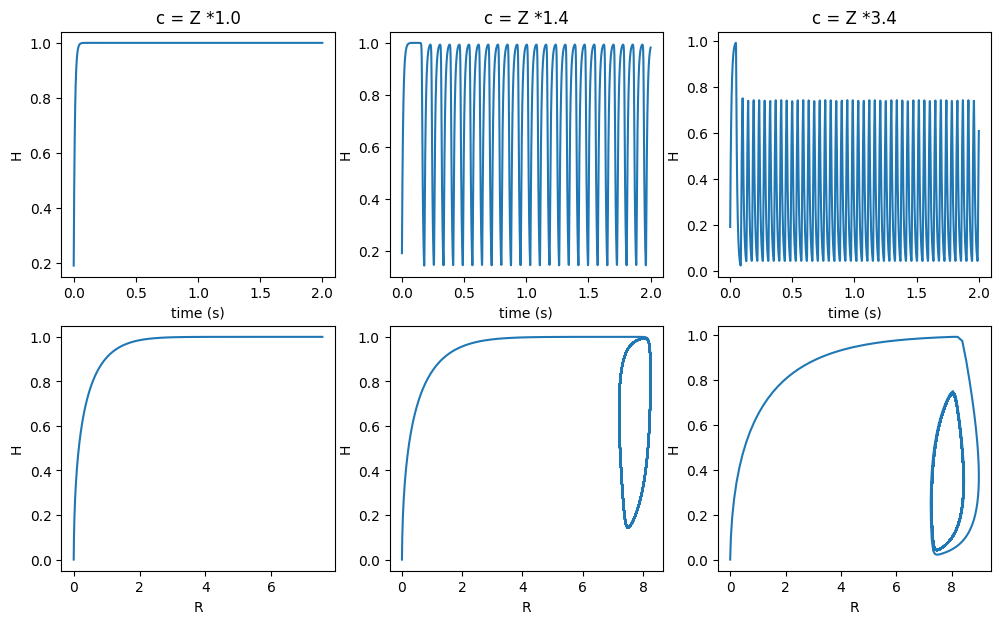

In [50]:
inv_c = np.array((c_vec[0],c_vec[3],c_vec[-1]))


plt.rcParams["figure.figsize"] = (12,7)

fig, axs = plt.subplots(2,3)

for i,c in enumerate(inv_c):
  params = [tau_h,tau_R,c,S]
  Zt, Ht, Rt = euler_dyn(Z,timevec,params,alpha_params,sig_param,t_start=0)

  axs[0,i].plot(timevec[1:],Ht[1+1:])
  axs[0,i].set_title('c = Z *' + str(round(c/Z,1)))
  axs[0,i].set_xlabel('time (s)')
  axs[0,i].set_ylabel('H')
  axs[1,i].plot(Rt,Ht)
  axs[1,i].set_xlabel('R')
  axs[1,i].set_ylabel('H')

### How do the dynamics change as a function of S?

<ipython-input-51-8b2cbe72d0c3>:48: RuntimeWarning: invalid value encountered in sqrt
  predf[i] = (1/(2*np.pi) * np.sqrt(4*c*(tau_h/tau_R)*(a/S)*Hx*(1-Hx) - ((a/S)*Hx*(1-Hx)+(tau_h/tau_R)-1)**2))/tau_h


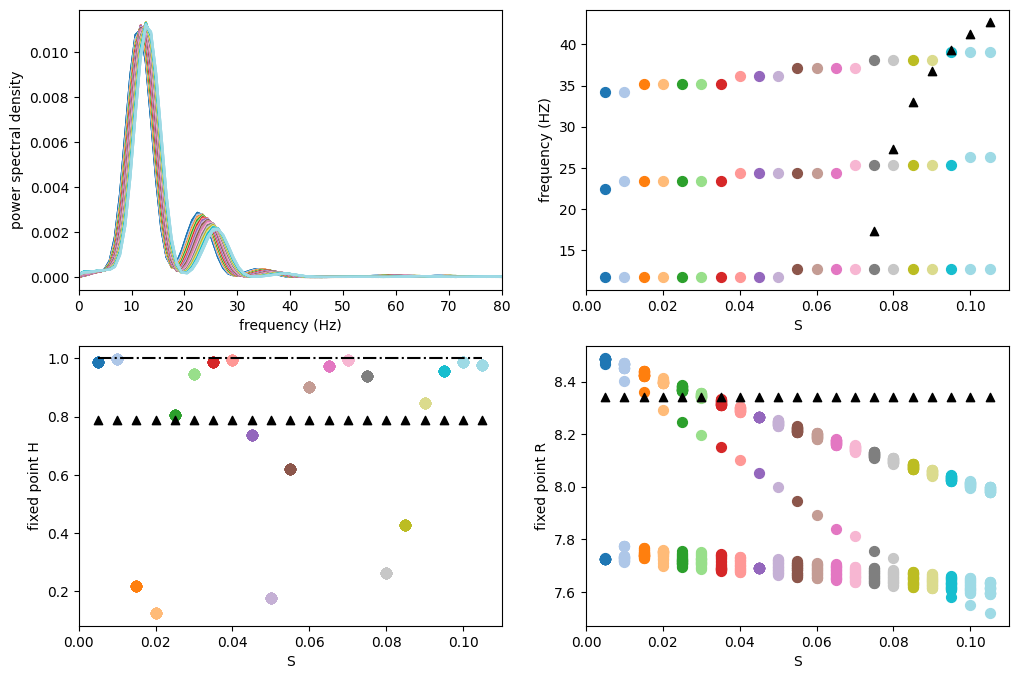

In [51]:
## The effect of S on the dynamics

cmap = plt.get_cmap('tab20')
cmap(0)[0:3]
import scipy

tau_h = 0.01
tau_R = 0.1
a = 2


# explore the maximum value for Z (dot product)
Z = torch.max(Z21).detach().cpu().item()


# fix c
c = 1.4*Z

# time
timevec = np.linspace(0,2,2000)

# explore S's
S_vec = np.arange(0.005,0.11,0.005)


Pxx = np.zeros((S_vec.shape[0],513))


plt.rcParams["figure.figsize"] = (12,8)

fig, axs = plt.subplots(2,2)

predf = np.zeros_like(S_vec)

## FREQUENCY
for i,S in enumerate(S_vec):
  params = [tau_h,tau_R,c,S]
  Zt, Ht, Rt = euler_dyn(Z,timevec,params,alpha_params,sig_param,t_start=0)

  f,Pxx[i] = scipy.signal.welch(Ht,fs=1000,nfft=1024)

  idx = scipy.signal.find_peaks(Pxx[i],prominence=(0.0001,None))

  freq = f[idx[0]]
  pow = idx[1]['prominences']

# predicted frequency
  predf[i] = (1/(2*np.pi) * np.sqrt(4*c*(tau_h/tau_R)*(a/S)*Hx*(1-Hx) - ((a/S)*Hx*(1-Hx)+(tau_h/tau_R)-1)**2))/tau_h

  for ii in range(len(freq)):
    #axs[0].text(freq[ii],pow[ii]+0.0005,str(round(c_vec[i])))
    axs[0,0].plot(f,Pxx[i],color=cmap(i)[0:3]);

for fi,pc in enumerate(Pxx):
  idx = scipy.signal.find_peaks(pc,prominence=(0.0001,None))

  freq = f[idx[0]]
  pow = idx[1]['prominences']

  for ii in range(len(freq)):
    axs[0,1].scatter(S_vec[fi],freq[ii],color=cmap(fi)[0:3],s=50)

  axs[0,1].scatter(S_vec[fi],predf[fi],color='k',marker="^")

axs[0,0].set_xlim((0, 80))
axs[0,0].set_xlabel('frequency (Hz)')
axs[0,0].set_ylabel('power spectral density')
axs[0,1].set_xlabel('S')
# axs[0,1].set_xticks(np.arange(S_vec[0],S_vec[-1]+1,3))
# axs[0,1].set_xticklabels(np.round(np.arange(c_vec[0],c_vec[-1]+1,3)/Z,decimals=1))

axs[0,1].set_ylabel('frequency (HZ)')
#axs[0,1].set_xlim((c_vec[0], c_vec[-1]))


## FIXED POINTS
for i,S in enumerate(S_vec):
  params = [tau_h,tau_R,c,S]
  Zt, Ht, Rt = euler_dyn(Z,timevec,params,alpha_params,sig_param,t_start=0)

  dH = np.diff(Ht)

  mark_sign_chan = np.array(())
  for h in range(dH.shape[0]-1):
    if (np.sign(dH[h])+np.sign(dH[h+1])) == 0:
      mark_sign_chan = np.append(mark_sign_chan,h)


  rval = [Rt[int(m-1)] for i,m in enumerate(mark_sign_chan)]

  # actual fixed point
  axs[1,1].scatter(np.tile(S,(len(rval),1)),rval,color=cmap(i)[0:3],s=50)

  # predicted by linear stability analysis
  rfix = (c/(c-1)*Z)
  axs[1,1].scatter(S,rfix,color='k',marker="^")

  axs[1,1].set_xlabel('S')
  # axs[1,1].set_xticklabels(np.round(np.arange(c_vec[0],c_vec[-1]+1,3)/Z,decimals=1))
  # axs[1,1].set_xticks(np.arange(c_vec[0],c_vec[-1]+1,3))

  axs[1,1].set_ylabel('fixed point R')

  dR = np.diff(Rt)

  mark_sign_chan = np.array(())
  for r in range(dR.shape[0]-1):
    if (np.sign(dR[r])+np.sign(dR[r+1])) == 0:
      mark_sign_chan = np.append(mark_sign_chan,h)

  hval = [Ht[int(m-1)] for i,m in enumerate(mark_sign_chan)]

  # actual fixed point
  axs[1,0].scatter(np.tile(S,(len(hval),1)),hval,color=cmap(i)[0:3],s=50)

  # predicted by linear stability analysis
  hfix = Z/(c-1)
  axs[1,0].scatter(S,hfix,color='k',marker="^")


  axs[1,0].set_xlabel('S')
  # axs[1,0].set_xticklabels(np.round(np.arange(c_vec[0],c_vec[-1]+1,3)/Z,decimals=1))
  # axs[1,0].set_xticks(np.arange(c_vec[0],c_vec[-1]+1,3))

  axs[1,0].set_ylabel('fixed point H')
# what the fixed point shoild be
axs[1,0].plot(S_vec,np.ones_like(S_vec)*sigmoid(Z,[2,-2.5]),color='k',linestyle='-.')

Several values for S would work



In [52]:
S_possible = [S_vec[:4],S_vec[9],S_vec[10],S_vec[15],S_vec[16]]
S_possible

[array([0.005, 0.01 , 0.015, 0.02 ]), 0.049999999999999996, 0.055, 0.08, 0.085]

<ipython-input-53-a1c5e476e95a>:47: RuntimeWarning: invalid value encountered in sqrt
  predf[i] = (1/(2*np.pi) * np.sqrt(4*c*(tau_h/tau_R)*(a/S)*Hx*(1-Hx) - ((a/S)*Hx*(1-Hx)+(tau_h/tau_R)-1)**2))/tau_h


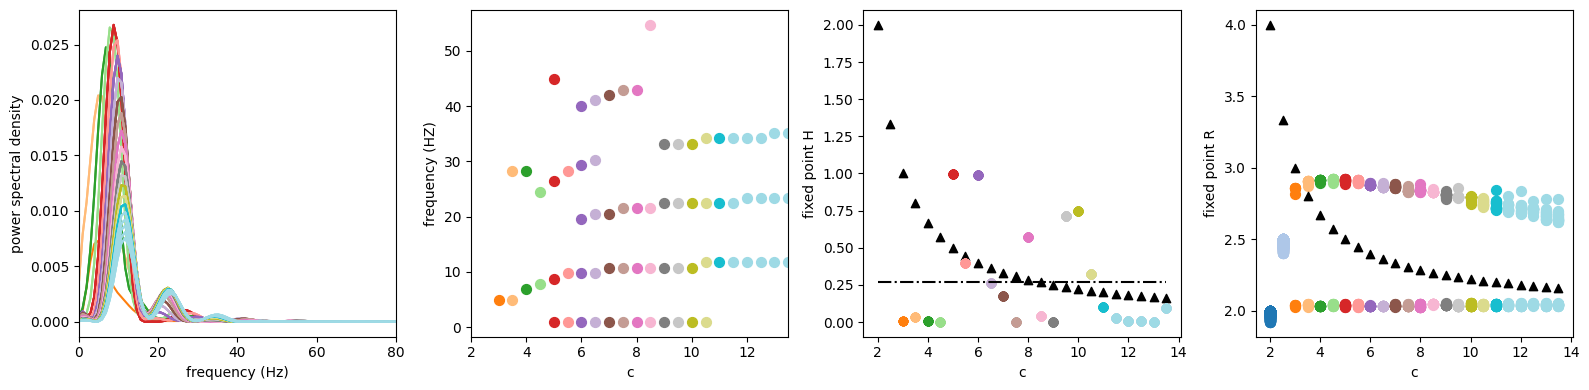

In [53]:
Z = 2


### The effect of c on the dynamics

cmap = plt.get_cmap('tab20')
import scipy

tau_h = 0.01
tau_R = 0.1
S = .01
a = 2

alpha_params = [10,0,0]
sig_param = [2, -2.5]

# time
timevec = np.linspace(0,2,2000)

# explore c's
c_vec = np.arange(Z,7*Z,.5)


Pxx = np.zeros((c_vec.shape[0],513))


plt.rcParams["figure.figsize"] = (16,4)

fig, axs = plt.subplots(1,4)

predf = np.zeros_like(c_vec)

## FREQUENCY
for i,c in enumerate(c_vec):
  params = [tau_h,tau_R,c,S]
  Zt, Ht, Rt = euler_dyn(Z,timevec,params,alpha_params,sig_param,t_start=0)

  f,Pxx[i] = scipy.signal.welch(Ht,fs=1000,nfft=1024)

  idx = scipy.signal.find_peaks(Pxx[i],prominence=(0.0001,None))

  freq = f[idx[0]]
  pow = idx[1]['prominences']

# predicted frequency
  Hx = Z/(c-1)
  predf[i] = (1/(2*np.pi) * np.sqrt(4*c*(tau_h/tau_R)*(a/S)*Hx*(1-Hx) - ((a/S)*Hx*(1-Hx)+(tau_h/tau_R)-1)**2))/tau_h

  for ii in range(len(freq)):
    #axs[0].text(freq[ii],pow[ii]+0.0005,str(round(c_vec[i])))
    axs[0].plot(f,Pxx[i],color=cmap(i)[0:3]);

for fi,pc in enumerate(Pxx):
  idx = scipy.signal.find_peaks(pc,prominence=(0.0001,None))

  freq = f[idx[0]]
  pow = idx[1]['prominences']

  for ii in range(len(freq)):
    axs[1].scatter(c_vec[fi],freq[ii],color=cmap(fi)[0:3],s=50)

  axs[1].scatter(c_vec[fi],predf[fi],color='k',marker="^")

axs[0].set_xlim((0, 80))
axs[0].set_xlabel('frequency (Hz)')
axs[0].set_ylabel('power spectral density')
axs[1].set_xlabel('c')
axs[1].set_xticks(np.arange(c_vec[0],c_vec[-1]+1,2))
#axs[0,1].set_xticklabels(np.round(np.arange(c_vec[0],c_vec[-1]+1,2),decimals=1))

axs[1].set_ylabel('frequency (HZ)')
axs[1].set_xlim((c_vec[0], c_vec[-1]))


## FIXED POINTS
for i,c in enumerate(c_vec):
  params = [tau_h,tau_R,c,S]
  Zt, Ht, Rt = euler_dyn(Z,timevec,params,alpha_params,sig_param,t_start=0)

  dH = np.diff(Ht)

  mark_sign_chan = np.array(())
  for h in range(dH.shape[0]-1):
    if (np.sign(dH[h])+np.sign(dH[h+1])) == 0:
      mark_sign_chan = np.append(mark_sign_chan,h)


  rval = [Rt[int(m-1)] for i,m in enumerate(mark_sign_chan)]

  # actual fixed point
  axs[3].scatter(np.tile(c,(len(rval),1)),rval,color=cmap(i)[0:3],s=50)

  # predicted by linear stability analysis
  rfix = (c/(c-1)*Z)
  axs[3].scatter(c,rfix,color='k',marker="^")

  axs[3].set_xlabel('c')
  #axs[0,3].set_xticklabels(np.round(np.arange(c_vec[0],c_vec[-1]+1,4),decimals=1))
  axs[3].set_xticks(np.arange(c_vec[0],c_vec[-1]+1,2))

  axs[3].set_ylabel('fixed point R')

  dR = np.diff(Rt)

  mark_sign_chan = np.array(())
  for r in range(dR.shape[0]-1):
    if (np.sign(dR[r])+np.sign(dR[r+1])) == 0:
      mark_sign_chan = np.append(mark_sign_chan,h)

  hval = [Ht[int(m-1)] for i,m in enumerate(mark_sign_chan)]

  # predicted by linear stability analysis
  hfix = Z/(c-1)
  axs[2].scatter(c,hfix,color='k',marker="^")


  axs[2].set_xlabel('c')
  #axs[0,2].set_xticklabels(np.round(np.arange(c_vec[0],c_vec[-1]+1,2)/Z,decimals=1))
  axs[2].set_xticks(np.arange(c_vec[0],c_vec[-1]+1,2))

  axs[2].set_ylabel('fixed point H')

  axs[2].scatter(np.tile(c,(len(hval),1)),hval,color=cmap(i))

axs[2].plot(c_vec,np.ones_like(c_vec)*sigmoid(Z,[2,-2.5]),color='k',linestyle='-.')

fig.tight_layout()

<ipython-input-55-5c35fed287bb>:47: RuntimeWarning: invalid value encountered in sqrt
  predf[i] = (1/(2*np.pi) * np.sqrt(4*c*(tau_h/tau_R)*(a/S)*Hx*(1-Hx) - ((a/S)*Hx*(1-Hx)+(tau_h/tau_R)-1)**2))/tau_h
<ipython-input-55-5c35fed287bb>:46: RuntimeWarning: divide by zero encountered in double_scalars
  Hx = Z/(c-1)
<ipython-input-55-5c35fed287bb>:94: RuntimeWarning: divide by zero encountered in double_scalars
  rfix = (c/(c-1)*Z)
<ipython-input-55-5c35fed287bb>:113: RuntimeWarning: divide by zero encountered in double_scalars
  hfix = Z/(c-1)


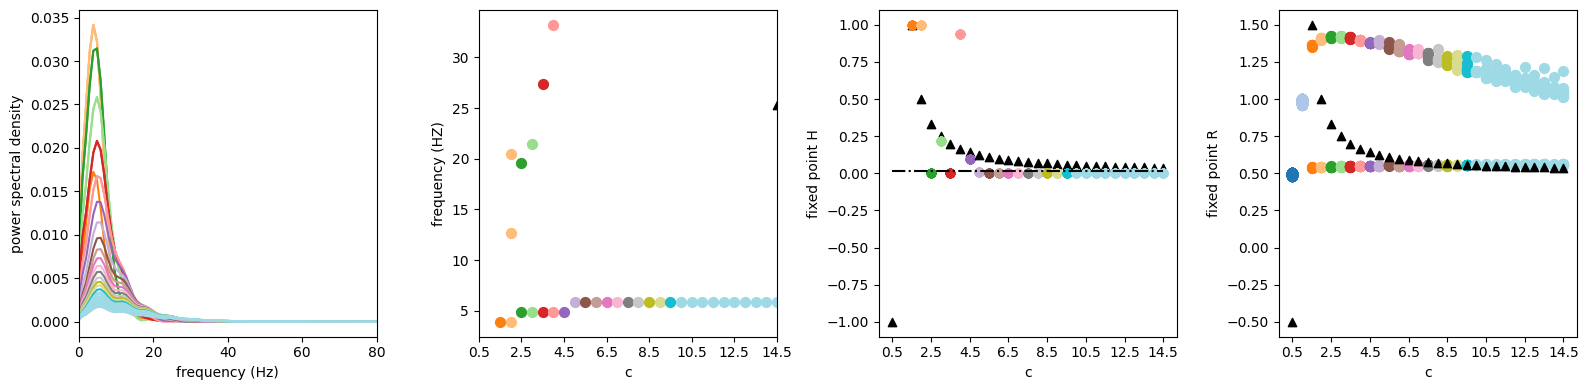

In [55]:
Z = 0.5


### The effect of c on the dynamics

cmap = plt.get_cmap('tab20')
import scipy

tau_h = 0.01
tau_R = 0.1
S = .01
a = 2

alpha_params = [10,0,0]
sig_param = [2, -2.5]

# time
timevec = np.linspace(0,2,2000)

# explore c's
c_vec = np.arange(Z,30*Z,.5)


Pxx = np.zeros((c_vec.shape[0],513))


plt.rcParams["figure.figsize"] = (16,4)

fig, axs = plt.subplots(1,4)

predf = np.zeros_like(c_vec)

## FREQUENCY
for i,c in enumerate(c_vec):
  params = [tau_h,tau_R,c,S]
  Zt, Ht, Rt = euler_dyn(Z,timevec,params,alpha_params,sig_param,t_start=0)

  f,Pxx[i] = scipy.signal.welch(Ht,fs=1000,nfft=1024)

  idx = scipy.signal.find_peaks(Pxx[i],prominence=(0.0001,None))

  freq = f[idx[0]]
  pow = idx[1]['prominences']

# predicted frequency
  Hx = Z/(c-1)
  predf[i] = (1/(2*np.pi) * np.sqrt(4*c*(tau_h/tau_R)*(a/S)*Hx*(1-Hx) - ((a/S)*Hx*(1-Hx)+(tau_h/tau_R)-1)**2))/tau_h

  for ii in range(len(freq)):
    #axs[0].text(freq[ii],pow[ii]+0.0005,str(round(c_vec[i])))
    axs[0].plot(f,Pxx[i],color=cmap(i)[0:3]);

for fi,pc in enumerate(Pxx):
  idx = scipy.signal.find_peaks(pc,prominence=(0.0001,None))

  freq = f[idx[0]]
  pow = idx[1]['prominences']

  for ii in range(len(freq)):
    axs[1].scatter(c_vec[fi],freq[ii],color=cmap(fi)[0:3],s=50)

  axs[1].scatter(c_vec[fi],predf[fi],color='k',marker="^")

axs[0].set_xlim((0, 80))
axs[0].set_xlabel('frequency (Hz)')
axs[0].set_ylabel('power spectral density')
axs[1].set_xlabel('c')
axs[1].set_xticks(np.arange(c_vec[0],c_vec[-1]+1,2))
#axs[0,1].set_xticklabels(np.round(np.arange(c_vec[0],c_vec[-1]+1,2),decimals=1))

axs[1].set_ylabel('frequency (HZ)')
axs[1].set_xlim((c_vec[0], c_vec[-1]))


## FIXED POINTS
for i,c in enumerate(c_vec):
  params = [tau_h,tau_R,c,S]
  Zt, Ht, Rt = euler_dyn(Z,timevec,params,alpha_params,sig_param,t_start=0)

  dH = np.diff(Ht)

  mark_sign_chan = np.array(())
  for h in range(dH.shape[0]-1):
    if (np.sign(dH[h])+np.sign(dH[h+1])) == 0:
      mark_sign_chan = np.append(mark_sign_chan,h)


  rval = [Rt[int(m-1)] for i,m in enumerate(mark_sign_chan)]

  # actual fixed point
  axs[3].scatter(np.tile(c,(len(rval),1)),rval,color=cmap(i)[0:3],s=50)

  # predicted by linear stability analysis
  rfix = (c/(c-1)*Z)
  axs[3].scatter(c,rfix,color='k',marker="^")

  axs[3].set_xlabel('c')
  #axs[0,3].set_xticklabels(np.round(np.arange(c_vec[0],c_vec[-1]+1,4),decimals=1))
  axs[3].set_xticks(np.arange(c_vec[0],c_vec[-1]+1,2))

  axs[3].set_ylabel('fixed point R')

  dR = np.diff(Rt)

  mark_sign_chan = np.array(())
  for r in range(dR.shape[0]-1):
    if (np.sign(dR[r])+np.sign(dR[r+1])) == 0:
      mark_sign_chan = np.append(mark_sign_chan,h)

  hval = [Ht[int(m-1)] for i,m in enumerate(mark_sign_chan)]

  # predicted by linear stability analysis
  hfix = Z/(c-1)
  axs[2].scatter(c,hfix,color='k',marker="^")


  axs[2].set_xlabel('c')
  #axs[0,2].set_xticklabels(np.round(np.arange(c_vec[0],c_vec[-1]+1,2)/Z,decimals=1))
  axs[2].set_xticks(np.arange(c_vec[0],c_vec[-1]+1,2))

  axs[2].set_ylabel('fixed point H')

  axs[2].scatter(np.tile(c,(len(hval),1)),hval,color=cmap(i))

axs[2].plot(c_vec,np.ones_like(c_vec)*sigmoid(Z,[2,-2.5]),color='k',linestyle='-.')

fig.tight_layout()

In [ ]:
c= c_vec[17]
c

## Thought: the fixed point Hx has to be the point where H changes direction

-> H is supposed to reach its activation sigmoid(Z,[2,-2.5])
we can solve this to find optimum parameters for c and S!!

$H* = \frac{Z}{c-1}-\frac{S}{c-1} \left( \frac{ln(\frac{1}{H*} - 1}{a} +b \right )$

$\sigma(Z) = \frac{Z}{c-1}-\frac{S}{c-1} \left( \frac{ln(\frac{1}{\sigma(Z)} - 1}{a} +b \right )$

$0 = \frac{Z}{c-1}-\frac{S}{c-1} \left( \frac{ln(\frac{1}{\sigma (Z)} - 1}{a} +b \right ) - \sigma (Z)$


**1) Solve for S**

$S = -(c-1) \frac{H* - \frac{Z}{c-1}}{\frac{logit(H*}{a}+b}$

with $logit(H*) = ln \left(\frac{H*}{1-H*}\right)$

**2) Solve for c**

$c = -\frac{S \left(\frac{logit(H*)}{a}+b \right) - Z - H*}{H*}$

In [ ]:
from scipy.optimize import fsolve

def find_S_c(x):

  # S = x[0]
  # Z = x[1]

  a = 2
  b = 2.5

  Z = 8
  H = sigmoid(Z,[a,b])

  logitH = np.log(H/(1-H))

  const = (logitH/a) + b

  # first part is S

  return [-(c-1) * (H-(Z/(c-1)))/(const) - x[0],(Z-x[0]*const)/H -1 - x[1]]

S,c = fsolve(find_S_c,[0,0])

In [ ]:
S,c

In [ ]:
params = [tau_h,tau_R,c,S]
Zt, Ht, Rt = euler_dyn(Z,timevec,params,alpha_params,sig_param,t_start=0)

plt.plot(timevec[1:],Ht[1+1:])

## Explore dynamics with one input

start dynamics at fixed points

$R = \frac{c}{c-1}Z$ and
$H = \frac{Z}{c-1}$

In [56]:
# to define a common c for all inputs, we need the maximum Z over all inputs

# get all Z's for all inputs
Zall = model2.forw_conv(x_train)[0]

# find maximum
maxZ = torch.max(Zall[:])


In [57]:
# get all activations for plots

Z21,H1,H2,O = model2.forw_conv(x_train[0])
Z22 = model2.fc1(H1)
H1 = H1.detach().cpu().numpy()
H2 = H2.detach().cpu().numpy()
O = O.detach().cpu().numpy()

#### Scale c for each input

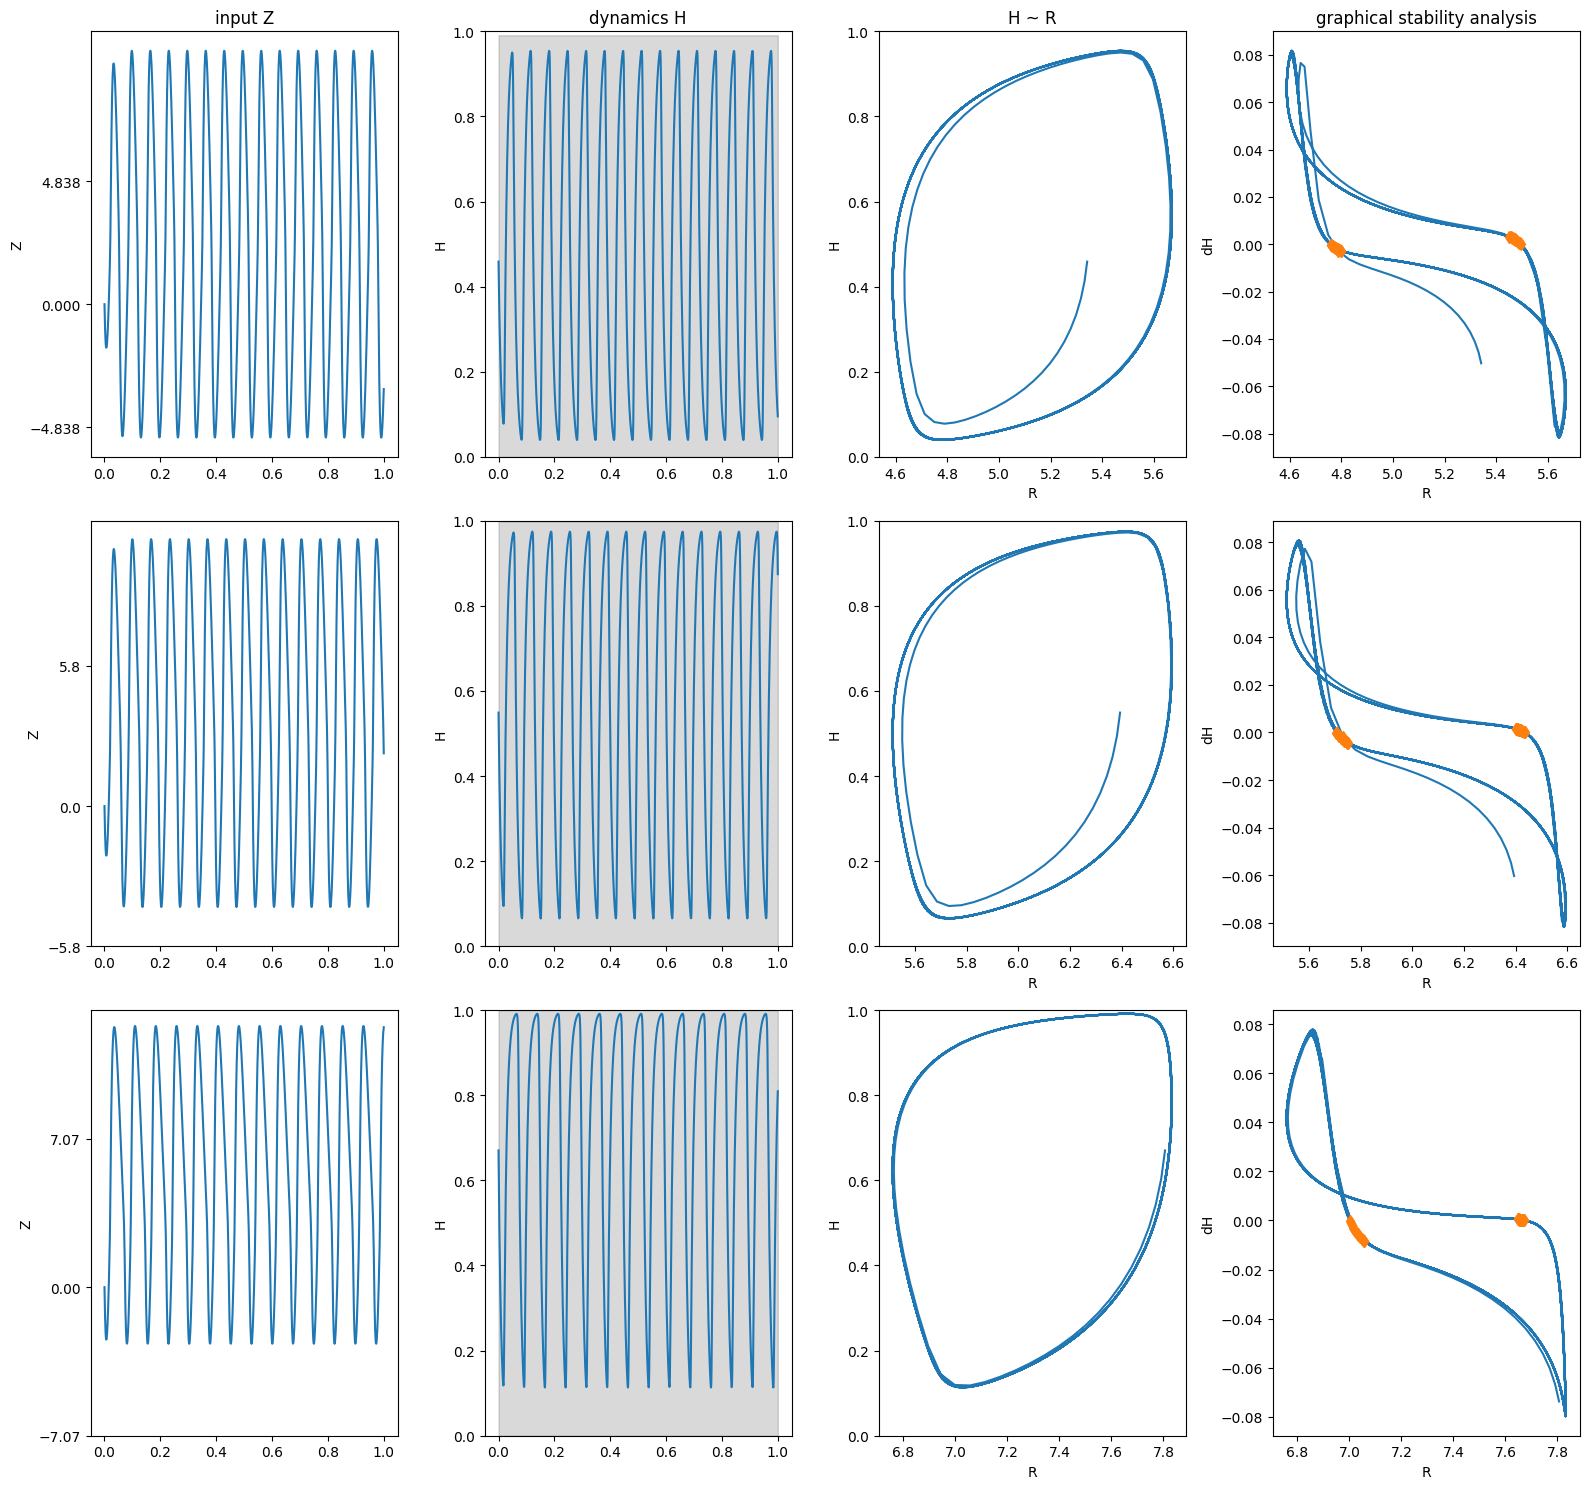

In [58]:
# Dynamics one input

tau_h = 0.01
tau_R = 0.1
S = .085
c = 10.5#1.4*maxZ

t_start = 0     # when stimulus presented
t = 0             # when to begin plot

params = [tau_h,tau_R,c,S]

# alpha parameters
afreq = [10,10]
aamp = [0,0]
aph = [0,0]

alpha_params = [afreq,aamp,aph]

timevec = np.linspace(0,1,1000)


Z1t,Z2t,H1t,R1t, H2t, R2t, Ot = euler_dyn_2layer(model2,x_train[0],params,timevec,alpha_params,DEVICE,t_start,start_fix=True)

# only plot nodes with unique Z's > 0

Z = Z21.detach().cpu()
Z_round = np.round(Z)
Z_round_idx = np.argsort(Z_round)
Z_round_sort = np.sort(Z_round)
Z_round_unique_idx = np.unique(Z_round_sort,return_index=True)

Z_idx = tuple((Z_round_unique_idx[0][Z_round_unique_idx[0]>0],Z_round_unique_idx[1][Z_round_unique_idx[0]>0]))

plt.rcParams["figure.figsize"] = (16,15)

#  UNCOMMENT FOR PLOT

fig, axs = plt.subplots(Z_idx[1].shape[0],4)

t = 0

for i,z in enumerate(Z_idx[1]):
  axs[i,0].plot(timevec[t:],Z1t[Z_round_idx[z],t+1:])
  axs[i,0].set_yticks((-Z[Z_round_idx[z]],0,Z[Z_round_idx[z]]))
  axs[i,0].set_ylabel('Z')
  axs[i,1].plot(timevec[t:],H1t[Z_round_idx[z],t+1:])

  if i == 0:
    axs[i,0].set_title('input Z')
    axs[i,1].set_title('dynamics H')
    axs[i,2].set_title('H ~ R')
    axs[i,3].set_title('graphical stability analysis')

#if aamp:
   # axs[i,1].plot(timevec[t:],0.5*np.sin(2*np.pi*afreq*timevec[t:]+aph)+0.5,color = 'k',linestyle='-.')
  axs[i,1].fill_between(timevec[t:], np.tile(0,timevec[t:].shape[0]), np.tile(H1[Z_round_idx[z]],timevec[t:].shape[0]), alpha=0.15, color=[0, 0, 0])
  axs[i,1].set_ylabel('H')

  axs[i,1].set_ylim(0,1)
  axs[i,2].plot(R1t[Z_round_idx[z],t+1:],H1t[Z_round_idx[z],t+1:])
  axs[i,2].set_ylim(0,1)
  axs[i,2].set_xlabel('R')
  axs[i,2].set_ylabel('H')

  dH = np.diff(H1t[Z_round_idx[z]])

  mark_sign_chan = np.array(())
  for h in range(dH.shape[0]-1):
    if (np.sign(dH[h])+np.sign(dH[h+1])) == 0:
      mark_sign_chan = np.append(mark_sign_chan,h)

  axs[i,3].plot(R1t[Z_round_idx[z],t+1:],dH)
  axs[i,3].plot(R1t[Z_round_idx[z],(t+1+mark_sign_chan).astype(int)],dH[(t+mark_sign_chan).astype(int)],'d')
  axs[i,3].set_xlabel('R')
  axs[i,3].set_ylabel('dH')


fig.tight_layout()

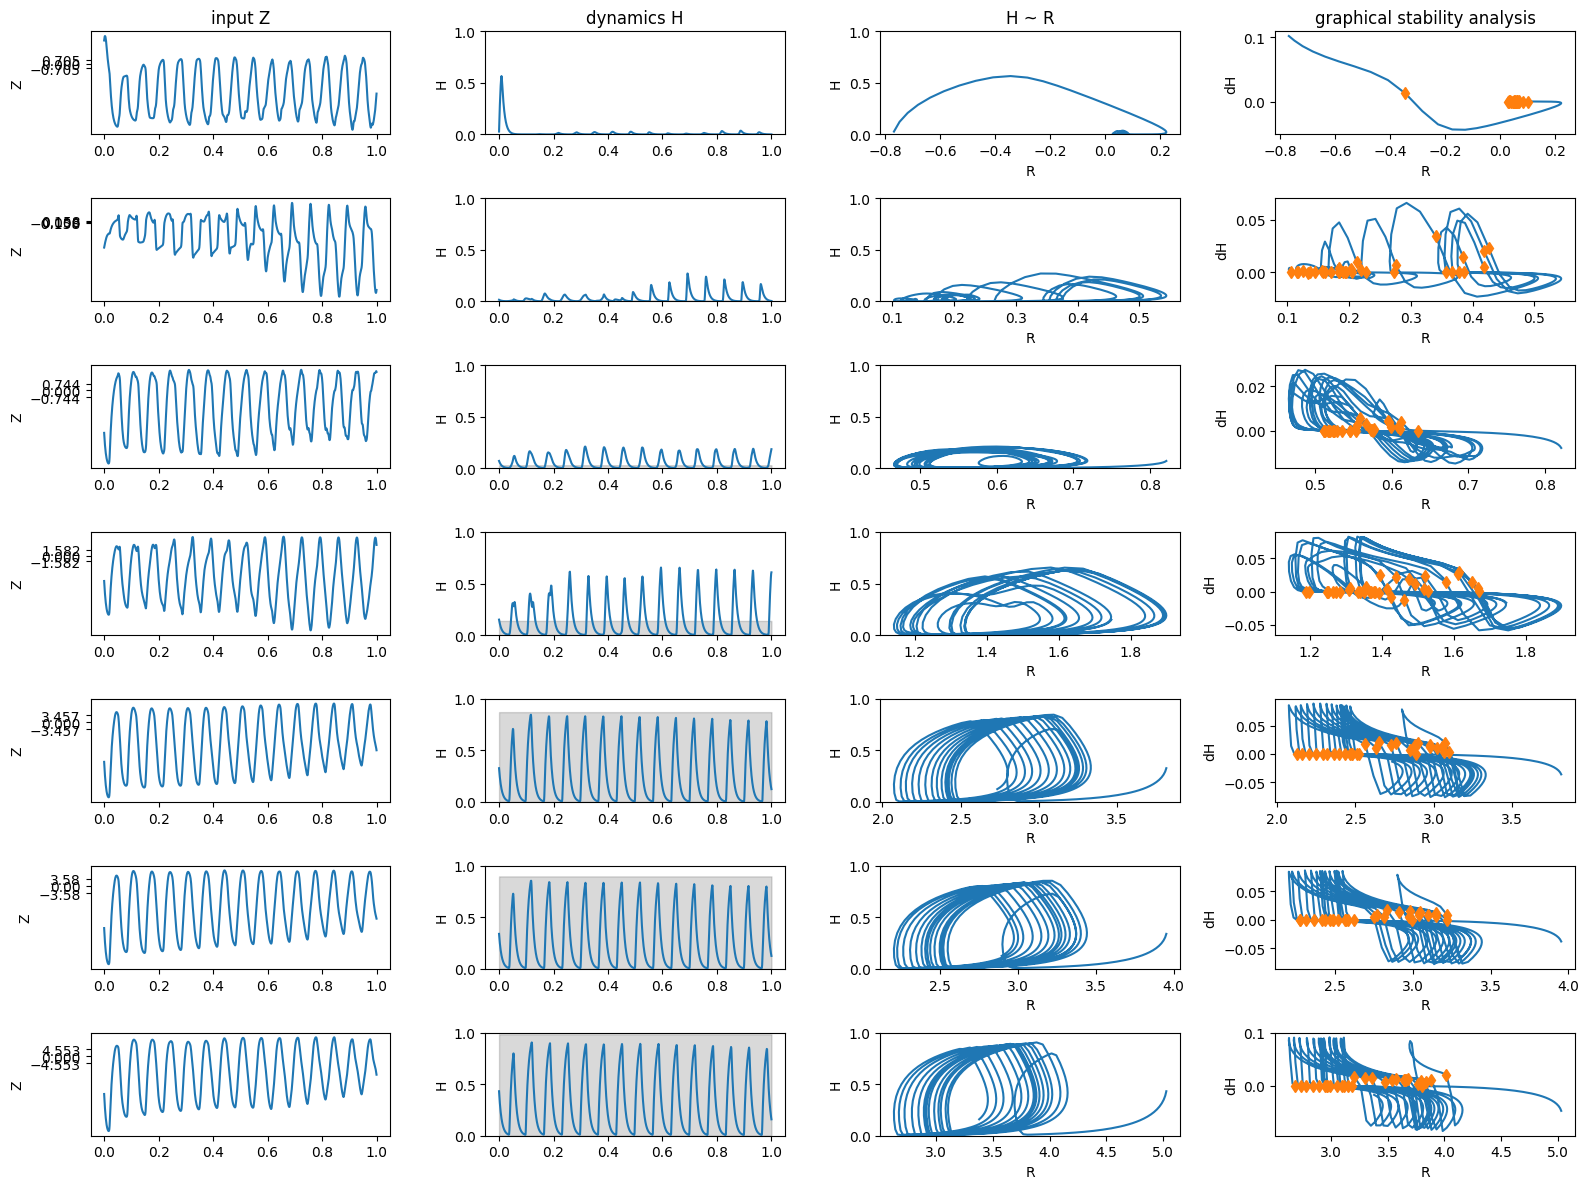

In [59]:
# Layer 2

Z = Z22.detach().cpu()
Z_round = np.round(Z)
Z_round_idx = np.argsort(Z_round)
Z_round_sort = np.sort(Z_round)
Z_round_unique_idx = np.unique(Z_round_sort,return_index=True)

plt.rcParams["figure.figsize"] = (16,12)


# UNCOMMENT FOR PLOT

fig, axs = plt.subplots(Z_round_unique_idx[1].shape[0],4)

t = 0

for i,z in enumerate(Z_round_unique_idx[1]):
  axs[i,0].plot(timevec[t:],Z2t[Z_round_idx[z],t+1:])
  axs[i,0].set_yticks((-Z[Z_round_idx[z]],0,Z[Z_round_idx[z]]))
  axs[i,0].set_ylabel('Z')
  axs[i,1].plot(timevec[t:],H2t[Z_round_idx[z],t+1:])


  if i == 0:
    axs[i,0].set_title('input Z')
    axs[i,1].set_title('dynamics H')
    axs[i,2].set_title('H ~ R')
    axs[i,3].set_title('graphical stability analysis')

#if aamp:
   # axs[i,1].plot(timevec[t:],0.5*np.sin(2*np.pi*afreq*timevec[t:]+aph)+0.5,color = 'k',linestyle='-.')
  axs[i,1].fill_between(timevec[t:], np.tile(0,timevec[t:].shape[0]), np.tile(H2[Z_round_idx[z]],timevec[t:].shape[0]), alpha=0.15, color=[0, 0, 0])
  axs[i,1].set_ylabel('H')

  axs[i,1].set_ylim(0,1)
  axs[i,2].plot(R2t[Z_round_idx[z],t+1:],H2t[Z_round_idx[z],t+1:])
  axs[i,2].set_ylim(0,1)
  axs[i,2].set_xlabel('R')
  axs[i,2].set_ylabel('H')

  dH = np.diff(H2t[Z_round_idx[z]])

  mark_sign_chan = np.array(())
  for h in range(dH.shape[0]-1):
    if (np.sign(dH[h])+np.sign(dH[h+1])) == 0:
      mark_sign_chan = np.append(mark_sign_chan,h)

  axs[i,3].plot(R2t[Z_round_idx[z],t+1:],dH)
  axs[i,3].plot(R2t[Z_round_idx[z],(t+1+mark_sign_chan).astype(int)],dH[(t+mark_sign_chan).astype(int)],'d')
  axs[i,3].set_xlabel('R')
  axs[i,3].set_ylabel('dH')


fig.tight_layout()

Layer 2 activations not super stable (because it receives dynamic inputs?) - but it might do. How does the output look?

Text(0, 0.5, 'activation')

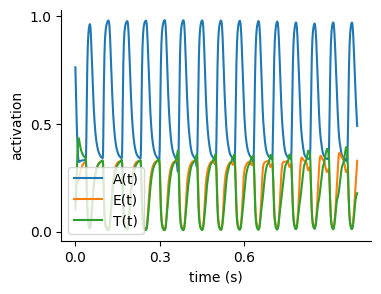

In [60]:
## Output

colmap = np.array([[1,25,89],[217,95,2],[0,0,0]])/255

plt.rcParams["figure.figsize"] = (4,3)

fig, ax = plt.subplots()
[ax.plot(timevec,ot[1:],linewidth=1.5) for i,ot in enumerate(Ot)];
ax.legend(('A(t)','E(t)','T(t)'),loc='lower left')
ax.spines[['right', 'top']].set_visible(False)
ax.set_xticks((0,0.3,0.6))
ax.set_yticks((0,0.5,1))
ax.set_xlabel('time (s)')
ax.set_ylabel(('activation'))

### Dynamics with alpha

In [61]:
# Dynamics one input

tau_h = 0.01
tau_R = 0.1
S = .085
c = 10.5

t_start = 0     # when stimulus presented
t = 0             # when to begin plot

params = [tau_h,tau_R,c,S]

# alpha parameters
afreq = [10,10]
aamp = [0.5,0.5]
aph = [0,-2*np.pi/100 * 10]

alpha_params = [afreq,aamp,aph]

timevec = np.linspace(0,1,1000)


Z1t,Z2t,H1t,R1t, H2t, R2t, Ot = euler_dyn_2layer(model2,x_train[0],params,timevec,alpha_params,DEVICE,t_start,start_fix=True)

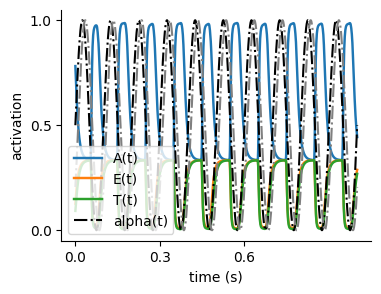

In [62]:
## Output

colmap = np.array([[1,25,89],[217,95,2],[0,0,0]])/255

plt.rcParams["figure.figsize"] = (4,3)

fig, ax = plt.subplots()
[ax.plot(timevec,ot[1:],linewidth=1.75) for i,ot in enumerate(Ot)];
if alpha_params[1][0]:
  ax.plot(timevec[t:],alpha_params[1][0]*np.sin(2*np.pi*alpha_params[0][0]*timevec[t:]+alpha_params[2][0])+alpha_params[1][0],color = 'k',linestyle='-.')

if alpha_params[1][1]:
  ax.plot(timevec[t:],alpha_params[1][1]*np.sin(2*np.pi*alpha_params[0][1]*timevec[t:]+alpha_params[2][1])+alpha_params[1][1], color = np.array((0.5, 0.5, 0.5)),linestyle='-.')


ax.spines[['right', 'top']].set_visible(False)
ax.set_xticks((0,0.3,0.6))
ax.set_yticks((0,0.5,1))
ax.set_xlabel('time (s)')
ax.set_ylabel(('activation'))

ax.legend(('A(t)','E(t)','T(t)','alpha(t)'),loc='lower left')

Entrainment!

### Two inputs

In [ ]:
10.5/maxZ

In [63]:
# Dynamics two inputs

tau_h = 0.01
tau_R = 0.1
S = .085
c = 1.5*maxZ

t_start = 0     # when stimulus presented
t = 0             # when to begin plot

params = [tau_h,tau_R,c,S]

# alpha parameters
afreq = [10,10]
aamp = [.5,.5]
aph = [0,-2*np.pi/100 * 10]

alpha_params = [afreq,aamp,aph]

timevec = np.linspace(0,1,1000)

inpt = x_train[0]*1.2 + x_train[5]*0.8


Z1t,Z2t,H1t,R1t, H2t, R2t, Ot = euler_dyn_2layer(model2,inpt,params,timevec,alpha_params,DEVICE,t_start,start_fix=True)

## Output

colmap = np.array([[1,25,89],[217,95,2],[0,0,0]])/255

# plt.rcParams["figure.figsize"] = (6,4)

# fig, ax = plt.subplots()
# [ax.plot(timevec,ot[1:],linewidth=1.75) for i,ot in enumerate(Ot)];
# if alpha_params[1][0]:
#   ax.plot(timevec[t:],alpha_params[1][0]*np.sin(2*np.pi*alpha_params[0][0]*timevec[t:]+alpha_params[2][0])+alpha_params[1][0],color = 'k',linestyle='-.')

# if alpha_params[1][1]:
#   ax.plot(timevec[t:],alpha_params[1][1]*np.sin(2*np.pi*alpha_params[0][1]*timevec[t:]+alpha_params[2][1])+alpha_params[1][1], color = np.array((0.5, 0.5, 0.5)),linestyle='-.')


# ax.spines[['right', 'top']].set_visible(False)
# ax.set_xticks((0,0.3,0.6))
# ax.set_yticks((0,0.5,1))
# ax.set_xlabel('time (s)')
# ax.set_ylabel(('activation'))

# ax.legend(('A(t)','E(t)','T(t)','alpha(t)'),loc='lower left')

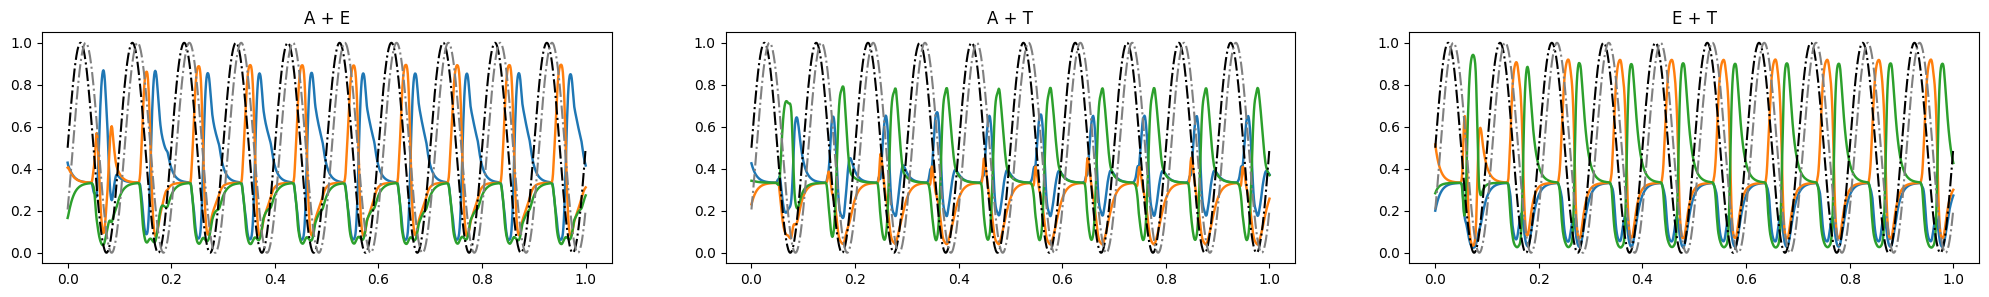

In [66]:
# try other combinations of inputs

idx = np.array((0,5,10))#,-1))
inp_combi = list(combinations(idx,2))           # possible combinations


labels = ['A', 'E', 'T']
label_comb = list(combinations(labels,2))
label_comb

plt.rcParams["figure.figsize"] = (25,3)


fig,axs = plt.subplots(1,3)

for i,comp_inp in enumerate(inp_combi):

  inpt = x_train[comp_inp[0]]*1.05 + x_train[comp_inp[1]]*.95

  Z1t,Z2t,H1t,R1t,H2t,R2t,Ot = euler_dyn_2layer(model2,inpt, params, timevec, alpha_params,DEVICE,inp_on=t_start,start_fix=True)

  [axs[i].plot(timevec,ot[1:],linewidth=1.75) for iot,ot in enumerate(Ot)];

  if alpha_params[1][0]:
    axs[i].plot(timevec[t:],alpha_params[1][0]*np.sin(2*np.pi*alpha_params[0][0]*timevec[t:]+alpha_params[2][0])+alpha_params[1][0],color = 'k',linestyle='-.')

  if alpha_params[1][1]:
    axs[i].plot(timevec[t:],alpha_params[1][1]*np.sin(2*np.pi*alpha_params[0][1]*timevec[t:]+alpha_params[2][1])+alpha_params[1][1], color = np.array((0.5, 0.5, 0.5)),linestyle='-.')


  axs[i].set_title(label_comb[i][0] + ' + ' + label_comb[i][1])

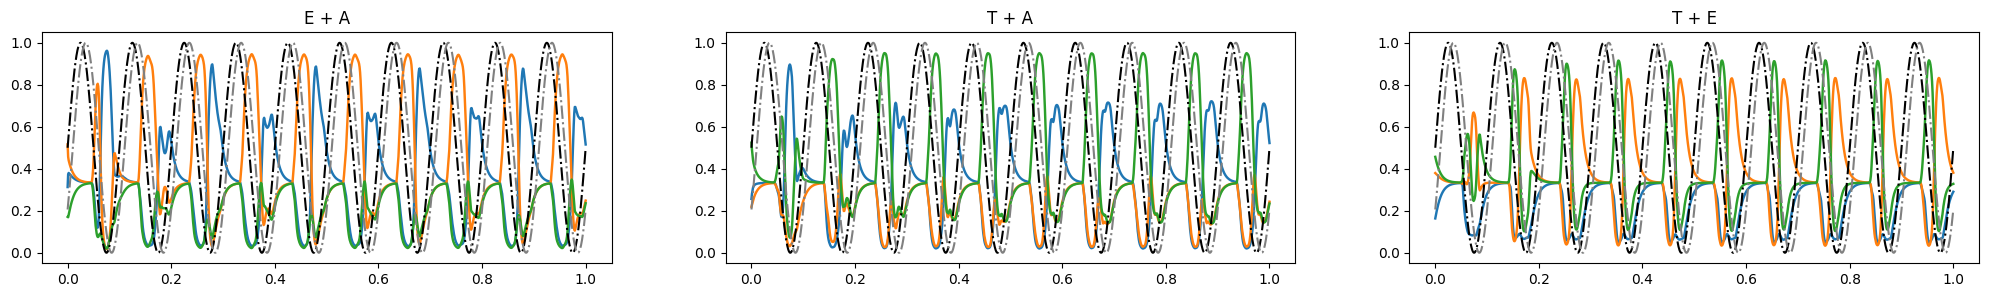

In [67]:
# try other combinations of inputs

idx = np.array((0,5,10))#,-1))
inp_combi = list(combinations(idx,2))           # possible combinations


labels = ['A', 'E', 'T']
label_comb = list(combinations(labels,2))
label_comb

plt.rcParams["figure.figsize"] = (25,3)


fig,axs = plt.subplots(1,3)

for i,comp_inp in enumerate(inp_combi):

  inpt = x_train[comp_inp[1]]*1.2 + x_train[comp_inp[0]]*.8

  Z1t,Z2t,H1t,R1t,H2t,R2t,Ot = euler_dyn_2layer(model2,inpt, params, timevec, alpha_params,DEVICE,inp_on=t_start,start_fix=True)

  [axs[i].plot(timevec,ot[1:],linewidth=1.75) for iot,ot in enumerate(Ot)];

  if alpha_params[1][0]:
    axs[i].plot(timevec[t:],alpha_params[1][0]*np.sin(2*np.pi*alpha_params[0][0]*timevec[t:]+alpha_params[2][0])+alpha_params[1][0],color = 'k',linestyle='-.')

  if alpha_params[1][1]:
    axs[i].plot(timevec[t:],alpha_params[1][1]*np.sin(2*np.pi*alpha_params[0][1]*timevec[t:]+alpha_params[2][1])+alpha_params[1][1], color = np.array((0.5, 0.5, 0.5)),linestyle='-.')


  axs[i].set_title(label_comb[i][1] + ' + ' + label_comb[i][0])

In [72]:
torch.max(x_train[-1] / torch.sum(x_train[-1]))

tensor(0.0086)

In [93]:
x_train.shape

torch.Size([12, 1, 56, 56])

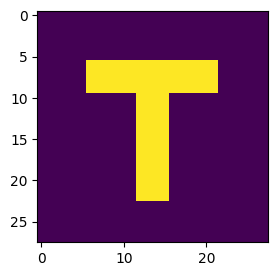

In [94]:
plt.imshow(x_train[-4,:,:28,0:28].squeeze().numpy())


In [98]:
torch.sum(x_train[4,:,:28,:28])

tensor(165.)